# Boundary Relation Tests

## Setup

### Imports

In [106]:
# Shared Packages
import pandas as pd

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [107]:
PRECISION = 2

In [108]:
%matplotlib inline

## Boundary Check process
1. Build slice table (index= slice, columns = ROI, Data= StructureSlice)
2. Select Primary & Secondary ROI
	- Slice range = Min(starting slice) to Max(ending slice)
3. Send all slices with both Primary and Secondary contours for standard relation testing 
4. Identify the boundary slices of the Primary and Secondary ROI
    - Boundary slices are slices that have a contour, but one of their neighbouring slices do not have a contour.
5. For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.
6. For each of these neighbouring slices select a Secondary slice for boundary tests:
	- If the slice has a Secondary contour, select that Secondary slice.
	- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.
	- If neither the neighbouring slice nor the same slice as the Primary boundary have a Secondary contour, do not select a Secondary slice. Boundary testing is not required.
7. Test the relation between the boundary Primary and the selected Secondary.
8. Apply a Primary boundary shift to the relation results.
9. If the selected Secondary is also a Secondary boundary, apply a Secondary boundary shift as well.
10. Merge all results and reduce to single relation

### Adjusting Boundary Slice Relations

For the beginning and ending slices of a structure the entire contour must
be treated as a boundary.  The structure does not have an interior on these
slices. In this case the “Interior” relations become “Boundary” relations.

***Error*** 
Shifting values in the DE-9IM relationship metric implies that the polygon 
boundaries become exterior to the structure.  This will cause tests for 
equality to fail.

***Solution***
The interior bits of the DE-9IM relationship metric must be combined with the 
boundary bits using "OR" logic.  This will allow the boundary bits to be
considered as part of the interior.

When hole boundaries are tested, only the "contour" boundary bits of the 'a' 
structure DE-9IM relationship


relation (DE27IM_Type): A triplet numeric DE-9IM relationship metric.
        

shift_type (str, optional): The polygon(s) that are boundaries:
- 'a' indicates that the first (primary) polygon is at a boundary.
- 'b' indicates that the second (secondary) polygon is at a boundary.
- 'both' (The default) indicates that both polygons are at a boundary.
- 'hole_in_a' indicates that the first polygon is at a boundary with a hole.
- 'hole_in_b' indicates that the second polygon is at a boundary with a hole.

# Current Bugs: 

1. The search for boundaries does not take into account holes in the structure.
2. Missing secondary boundary test
3. Borders definition appears to be incorrect

## Need to do boundary checks by region not by structure
- Make a Region class with the following attributes:
    - ROI: ROI_Type, 
    - slice: SliceIndexType, 
    - is_hole: bool,
    - is_boundary: bool,
    - region_labels: List[str], 
    - polygon: ContourType
- Step through all structures and separate each slice into individual polygons 
    and holes (Regions)
- Apply region labels, based on overlapping polygons.
  - Set unique labels for each region on the first slice: 'a', 'b' ...
  - find overlapping polygons on the next slice and give them the same 
      region labels.
  - A polygon can be in multiple regions.
- If a polygon in the current region is not matched to a polygon in the next 
    region, it is a boundary polygon.
- If a polygon in the next region is not matched with a polygon in the current 
    region, it is a boundary polygon. Assign it to a new region
- Store as a list of dictionaries with keys: ROI, slice, is_hole, polygon
- convert to a DataFrame and sort on ROI and slice


**What about two regions that converge into one?**
- Keep distinct for now. (A polygon can be in multiple regions)

### Managing holes
The boundaries of holes must also be checked
- `adjust_boundary_relation` will need to be updated to include `shift_type`s for holes:
     - *hole_in_a* 
     - *hole_in_b*
     - *hole_in_both*
- The *holes* `shift_type` shifts the interior relation to a boundary relation only for the *contour* part.  The *exterior* and *hull* relation parts are not shifted.

- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.
  

### secondary boundary tests
- Applies to the Secondary ROI in the same way as the Primary ROI.
- The `boundary_match` and `match_neighbour_slices` functions will need to be adjusted to work for secondary boundaries as well.

|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Borders          |  `FF*FT****`  |   `T*T*F*FF*`   | `*********` |
|Borders result   |  `000011001`  |   `000011001`   | `000011001` |
|Interior Borders |  `FF*FT****`  |   `T***T****`   | `*********` |
|Result           |  `111001001`  |   `111001001`   | `001011101` |
                
**BORDERS:** The two structures share a common exterior boundary.

**BORDERS_INTERIOR:** The two structures share a common boundary and one is within the other.
    


|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Overlaps         |  `T*T***T**`  |   `*********`   | `*********` |
|Overlaps result  |  `110010001`  |   `110010001`   | `110010001` |

                
**OVERLAPS:** The two structures share a common region.
    

![alt text](Images/DE-9IM.png)

![alt text](../reference/RelationshipTreeDiagram.svg)

In [109]:
def is_boundary(region):
    if isinstance(region, Region):
        return region.is_boundary
    return False


def is_hole(region):
    if isinstance(region, Region):
        return region.is_hole
    return False

def find_boundary_slices(region_table):
    has_boundary = region_table.map(is_boundary)
    boundaries = has_boundary.stack('ROI', future_stack=True)
    boundaries = boundaries.fillna(0).astype(bool)
    boundaries = boundaries.apply(any, axis='columns')
    boundaries = boundaries.unstack('ROI')
    return boundaries

In [110]:
def neighbour_match(slice_table: pd.DataFrame,
                    structure_boundaries: pd.DataFrame,
                    primary: ROI_Type, secondary: ROI_Type,
                    shift_dir: int, has_primary=False):
    # Match the slices with primary boundaries to the neighbouring secondary
    # structures in the direction of shift_dir
    # Identify slices without the primary structure, but with the secondary structure
    secondary_slices = slice_table.map(empty_structure)[[primary, secondary]]
    secondary_slices[secondary] = ~secondary_slices[secondary]
    # Identify slices without the primary structure, but with the secondary structure
    secondary_slices = secondary_slices.apply(all, axis='columns')
    secondary_slices[secondary] = secondary_slices[secondary].shift(shift_dir)
    secondary_slices = secondary_slices.fillna(0).astype(bool)

    # Shift the primary structure boundaries to a neighbouring slice
    primary_b = structure_boundaries[primary]
    idx_p = primary_b.index.to_series()
    idx_p.name = primary

    # Identify slices without the primary structure, but with the secondary structure
    secondary_slices = slice_table.map(empty_structure)[[primary, secondary]]
    secondary_slices[secondary] = secondary_slices[secondary].shift(shift_dir)
    secondary_slices = secondary_slices.fillna(0).astype(bool)
    secondary_slices[primary] = ~secondary_slices[primary]
    secondary_slices[secondary] = ~secondary_slices[secondary]
    idx_2 = secondary_slices.index.to_series().shift(shift_dir)
    idx_2.name = secondary

    # Match those slices with neighbouring primary structure boundaries.

    match = pd.concat([primary_b, secondary_slices], axis='columns')
    match = match.fillna(0).astype(bool)
    match = match.apply(all, axis='columns')
    matched_indexes = pd.concat([idx_p, idx_2], axis='columns')[match]
    return matched_indexes

## Test structures


#### Embedded boxes

![ContainsCubes](ContainsCubes.png)

In [111]:
def embedded_boxes():
    slice_spacing = 0.5
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                                spacing=slice_spacing)
    # embedded boxes
    cube6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    cube3 = make_box(roi_num=2, width=3, offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([cube6, cube3, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table

#### Concentric cylinders starting on the same slice
  
<img src="Images\Boundaries\PartitionSup3D.png" alt="PartitionSup3D" style="height:50px;">
<img src="Images\Boundaries\PartitionSup2D.png" alt="PartitionSup2D" style="height:30px;">

In [112]:
def concentric_cylinders_same_start():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    sup_partition = make_vertical_cylinder(roi_num=2, radius=1, length=0.4,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, sup_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [113]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # cylinder completely inside of a hole
    surrounds_cylinder = make_vertical_cylinder(roi_num=3, radius=1, length=0.3,
                                             offset_x=-2.5, offset_z=-0.1,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder, surrounds_cylinder,
                            bordering_cylinder1, bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [114]:
slice_table = embedded_boxes()
region_table = make_region_table(slice_table)
selected_roi = [1, 2]

In [115]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'

merged_relations(mid_relations).identify_relation()

<RelationshipType.CONTAINS: 8>

#### Bordering Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice has a Secondary contour, select that Secondary slice.

![Bordering cylinders](FreeCAD_Scripts/BorderingCylinders.png)

In [116]:
def bordering_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, bordering_cylinder1,
                            bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Partition Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.


In [117]:
def partitions_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, partitioning_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [118]:
def overlapping_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.9,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [119]:
def cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # cylinder with matching borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # cylinder overlapping positive
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.8,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder,
                            partitioning_cylinder,
                            bordering_cylinder1, bordering_cylinder2,
                            overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


## Boundary Check process
1. Build slice table (index= slice, columns = ROI, Data= StructureSlice)
2. Select Primary & Secondary ROI
	- Slice range = Min(starting slice) to Max(ending slice)
3. Send all slices with both Primary and Secondary contours for standard relation testing 
4. Identify the boundary slices of the Primary and Secondary ROI
    - Boundary slices are slices that have a contour, but one of their neighbouring slices do not have a contour.
5. For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.
6. For each of these neighbouring slices select a Secondary slice for boundary tests:
	- If the slice has a Secondary contour, select that Secondary slice.
	- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.
	- If neither the neighbouring slice nor the same slice as the Primary boundary have a Secondary contour, do not select a Secondary slice. Boundary testing is not required.
7. Test the relation between the boundary Primary and the selected Secondary.
8. Apply a Primary boundary shift to the relation results.
9. If the selected Secondary is also a Secondary boundary, apply a Secondary boundary shift as well.
10. Merge all results and reduce to single relation

In [120]:
slice_table = cylinders()
region_table = make_region_table(slice_table)


In [121]:
selected_roi = [1, 5]


In [122]:
holes = region_table.map(is_hole).apply(any)
structure_regions = region_table.loc[:,~holes][selected_roi]
structure_boundaries = find_boundary_slices(structure_regions)


In [123]:
poly_a, poly_b = selected_roi


- For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.


In [124]:
# Slices that have both primary and secondary structures.
s_p = slice_table.map(empty_structure, invert=True)[selected_roi]
s_p = s_p.apply(all, axis='columns')

# slices that have the secondary structure but not the primary structure.
s_not_p = slice_table.map(empty_structure)[selected_roi].copy()
s_not_p[poly_b] = ~s_not_p[poly_b]
s_not_p = s_not_p.apply(all, axis='columns')

# slices that are boundaries of the primary structure.
primary_b = structure_boundaries[poly_a].copy()


In [125]:
def match_slice(primary_b: pd.Series, sp: pd.Series, selected_roi, shift_dir: int):
    poly_a, poly_b = selected_roi
    n1 = sp & primary_b.shift(shift_dir)
    b1 = n1.index.to_series().shift(shift_dir)[n1]
    b1.name=poly_a
    b1 = b1.reset_index()
    b1.columns = [poly_b, poly_a]
    return b1


- If the neighbouring slice has a Secondary contour, select that Secondary slice.
	

In [126]:

bp = match_slice(primary_b, s_not_p, selected_roi, 1)
bn = match_slice(primary_b, s_not_p, selected_roi, -1)


- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

In [127]:
b0 = match_slice(primary_b, s_p, selected_roi, 0)


In [128]:
bn

,5,1


In [133]:
selected_roi = [1, 5]
a = slice_table.map(empty_structure, invert=True)[selected_roi]
a.columns = [f'HasContour({roi})' for roi in selected_roi]
b = structure_boundaries[selected_roi]
b.columns = [f'IsBoundary({roi})' for roi in selected_roi]
pd.concat([a, b], axis='columns')

,HasContour(1),HasContour(5),IsBoundary(1),IsBoundary(5)
-0.5,False,False,False,False
-0.4,False,False,False,False
-0.3,True,True,True,True
-0.2,True,True,False,False
-0.1,True,True,False,False
0.0,True,True,False,False
0.1,True,True,False,False
0.2,True,True,False,False
0.3,True,True,True,False
0.4,False,True,False,True


# Question
- Slice 0.4 is a boundary for #5, and is a neighbour to the boundary for #1.
- Will it get the relation wrong if I test it as a boundary for both #1 and #5?
> Probably not, because regular relations are also tested  for slice 0.4.  
> For 0.4, #5 will be external to #1.


In [139]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
print(mid_relations[0.4])

|000|	|000|	|000|
|000|	|000|	|000|
|000|	|000|	|000|



## **Slice 0.4 should show #5 is external to #1.**

In [ ]:

for slice, rel in mid_relations.to_dict().items():
    print(f"Slice {slice}: \n{rel}\n")

In [ ]:
merged_relations(mid_relations).identify_relation()

In [94]:
secondary_slices = slice_table.map(empty_structure)[selected_roi]
secondary_slices[poly_b] = ~secondary_slices[poly_b]
secondary_slices = secondary_slices.apply(all, axis='columns')

pos_slices = secondary_slices.shift(1).fillna(0).astype(bool)
idx_p = secondary_slices.index.to_series().shift(1)
match = pd.concat([primary_b, pos_slices], axis='columns')
match = match.fillna(0).astype(bool)
match = match.apply(all, axis='columns')
a = idx_p[match]

neg_slices = secondary_slices.shift(-1).fillna(0).astype(bool)
idx_n = secondary_slices.index.to_series().shift(-1)
match = pd.concat([primary_b, neg_slices], axis='columns')
match = match.fillna(0).astype(bool)
match = match.apply(all, axis='columns')
b = idx_n[match]

s_slices = secondary_slices.shift(0).fillna(0).astype(bool)

idx_s = secondary_slices.index.to_series().shift(0)
match = pd.concat([primary_b, s_slices], axis='columns')
match = match.fillna(0).astype(bool)
match = match.apply(all, axis='columns')
c = idx_s[match]


pd.concat([a, b, c], axis='index')

Slice Index
0.3    0.4
Name: Slice Index, dtype: float64

In [95]:
region_table

ROI                                                    0  \
Label                                                  a   
Slice                                                      
-0.5   Region(roi=0, slice=-0.5, is_hole=False, is_bo...   
-0.4   Region(roi=0, slice=-0.4, is_hole=False, is_bo...   
-0.3   Region(roi=0, slice=-0.3, is_hole=False, is_bo...   
-0.2   Region(roi=0, slice=-0.2, is_hole=False, is_bo...   
-0.1   Region(roi=0, slice=-0.1, is_hole=False, is_bo...   
 0.0   Region(roi=0, slice=0.0, is_hole=False, is_bou...   
 0.1   Region(roi=0, slice=0.1, is_hole=False, is_bou...   
 0.2   Region(roi=0, slice=0.2, is_hole=False, is_bou...   
 0.3   Region(roi=0, slice=0.3, is_hole=False, is_bou...   
 0.4   Region(roi=0, slice=0.4, is_hole=False, is_bou...   
 0.5   Region(roi=0, slice=0.5, is_hole=False, is_bou...   

ROI                                                    1  \
Label                                                  b   
Slice                                                      
-0.5                                                 NaN   
-0.4                                                 NaN   
-0.3   Region(roi=1, slice=-0.3, is_hole=False, is_bo...   
-0.2   Region(roi=1, slice=-0.2, is_hole=False, is_bo...   
-0.1   Region(roi=1, slice=-0.1, is_hole=False, is_bo...   
 0.0   Region(roi=1, slice=0.0, is_hole=False, is_bou...   
 0.1   Region(roi=1, slice=0.1, is_hole=False, is_bou...   
 0.2   Region(roi=1, slice=0.2, is_hole=False, is_bou...   
 0.3   Region(roi=1, slice=0.3, is_hole=False, is_bou...   
 0.4                                                 NaN   
 0.5                                                 NaN   

ROI                                                    2  \
Label                                                  c   
Slice                                                      
-0.5                                                 NaN   
-0.4                                                 NaN   
-0.3                                                 NaN   
-0.2   Region(roi=2, slice=-0.2, is_hole=False, is_bo...   
-0.1   Region(roi=2, slice=-0.1, is_hole=False, is_bo...   
 0.0   Region(roi=2, slice=0.0, is_hole=False, is_bou...   
 0.1   Region(roi=2, slice=0.1, is_hole=False, is_bou...   
 0.2   Region(roi=2, slice=0.2, is_hole=False, is_bou...   
 0.3                                                 NaN   
 0.4                                                 NaN   
 0.5                                                 NaN   

ROI                                                    3  \
Label                                                  d   
Slice                                                      
-0.5                                                 NaN   
-0.4                                                 NaN   
-0.3   Region(roi=3, slice=-0.3, is_hole=False, is_bo...   
-0.2   Region(roi=3, slice=-0.2, is_hole=False, is_bo...   
-0.1   Region(roi=3, slice=-0.1, is_hole=False, is_bo...   
 0.0   Region(roi=3, slice=0.0, is_hole=False, is_bou...   
 0.1   Region(roi=3, slice=0.1, is_hole=False, is_bou...   
 0.2   Region(roi=3, slice=0.2, is_hole=False, is_bou...   
 0.3   Region(roi=3, slice=0.3, is_hole=False, is_bou...   
 0.4                                                 NaN   
 0.5                                                 NaN   

ROI                                                    4  \
Label                                                  e   
Slice                                                      
-0.5   Region(roi=4, slice=-0.5, is_hole=False, is_bo...   
-0.4   Region(roi=4, slice=-0.4, is_hole=False, is_bo...   
-0.3                                                 NaN   
-0.2                                                 NaN   
-0.1                                                 NaN   
 0.0                                                 NaN   
 0.1                                                 NaN   
 0.2                                

In [96]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
#mid_relations

In [97]:
slice_table = cylinders()
region_table = make_region_table(slice_table)
selected_roi = [1, 4]


In [98]:
selected_roi = [1, 3]

In [99]:
poly_a, poly_b = selected_roi

primary_b = structure_boundaries[poly_a]
primary_b
secondary_slices = slice_table.map(empty_structure)[selected_roi]
secondary_slices[poly_b] = ~secondary_slices[poly_b]
secondary_slices

ROI Num,1,3
Slice Index,,
-0.5,True,False
-0.4,True,False
-0.3,False,True
-0.2,False,True
-0.1,False,True
0.0,False,True
0.1,False,True
0.2,False,True
0.3,False,True


In [100]:
secondary_slices = secondary_slices.apply(all, axis='columns')

pos_slices = secondary_slices.shift(1).fillna(0).astype(bool)
idx_p = secondary_slices.index.to_series().shift(1)
match = pd.concat([primary_b, pos_slices], axis='columns')
match = match.fillna(0).astype(bool)
match = match.apply(all, axis='columns')
a = idx_p[match]
a


Series([], Name: Slice Index, dtype: float64)

In [101]:
neg_slices = secondary_slices.shift(-1).fillna(0).astype(bool)
idx_n = secondary_slices.index.to_series().shift(-1)
match = pd.concat([primary_b, neg_slices], axis='columns')
match = match.fillna(0).astype(bool)
match = match.apply(all, axis='columns')
b = idx_n[match]
b


Series([], Name: Slice Index, dtype: float64)

In [102]:
s_slices = secondary_slices.shift(0).fillna(0).astype(bool)

idx_s = secondary_slices.index.to_series().shift(0)
match = pd.concat([primary_b, s_slices], axis='columns')
match = match.fillna(0).astype(bool)
match = match.apply(all, axis='columns')
c = idx_s[match]
c


Series([], Name: Slice Index, dtype: float64)

In [103]:
s_slices

Slice Index
-0.5    False
-0.4    False
-0.3    False
-0.2    False
-0.1    False
 0.0    False
 0.1    False
 0.2    False
 0.3    False
 0.4    False
 0.5    False
dtype: bool

In [104]:

pd.concat([a, b, c], axis='index')

Series([], Name: Slice Index, dtype: float64)

In [105]:

poly_a, poly_b = selected_roi
a = pd.concat([
    neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, -1),
    neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, 1)
    ])
a

KeyError: 3

In [148]:
neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, 0, has_primary=True),

(Empty DataFrame
 Columns: [1, 4]
 Index: [],)

In [152]:
slice_table = partitions_cylinder()
region_table = make_region_table(slice_table)
selected_roi = [1, 3]

In [153]:
poly_a, poly_b = selected_roi

In [ ]:
secondary_slices = slice_table.map(empty_structure)[[poly_a, poly_b,4]]
secondary_slices[poly_b] = ~secondary_slices[poly_b]
secondary_slices

KeyError: '[4] not in index'

In [150]:

poly_a, poly_b = selected_roi
a = pd.concat([
    neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, -1),
    neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, 1)
    ])
a

,1,3
-0.3,-0.3,-0.2
0.3,0.3,0.2


In [ ]:
neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, 0, has_primary=True),

(        1    3
 -0.3 -0.3 -0.3
  0.3  0.3  0.3,)

In [ ]:
slice_table = overlapping_cylinder()
region_table = make_region_table(slice_table)
selected_roi = [1, 5]

In [74]:
poly_a, poly_b = selected_roi
a = pd.concat([
    neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, -1),
    neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, 1)
    ])

In [75]:
a

,1,5
0.4,0.3,0.4


In [76]:
neighbour_match(slice_table, structure_boundaries, poly_a, poly_b, 0, has_primary=True),

(        1    5
 -0.3 -0.3 -0.3
  0.3  0.3  0.3,)

In [65]:
(structure_boundaries.loc[-0.3,1], structure_boundaries.loc[-0.4,4])


(True, True)

In [66]:
(structure_boundaries.loc[0.3,1], structure_boundaries.loc[0.4,4])


(True, True)

In [ ]:
DE27IM(slice_table.loc[-0.3,1],slice_table.loc[-0.4,4])

KeyError: 4

In [19]:
a = structure_boundaries[1].shift(1)
#a.name = 'Boundary'
b = slice_table.map(empty_structure)[selected_roi]
#b.columns = ['EmptyPrimary', 'EmptySecondary']
c = pd.concat([a, b], axis='columns')
c = c.fillna(0).astype(bool)
c = c.apply(all, axis='columns')

idx = a.index.to_series().shift(1)
idx.name = 'PrimarySlice'
idx2 = c.index.to_series()
idx2.name = 'SecondarySlice'
pd.concat([idx, idx2], axis='columns')[c]

,PrimarySlice,SecondarySlice


In [20]:
structure_boundaries

ROI,1,4
Slice,,
-0.5,False,True
-0.4,False,True
-0.3,True,False
-0.2,False,False
-0.1,False,False
0.0,False,False
0.1,False,False
0.2,False,False
0.3,True,False


#### Confines Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

  
![Confines cylinder](FreeCAD_Scripts/confines_cylinder.png)



5. Match hole boundary slices for boundary tests:
   - For each hole boundary slice of the Primary ROI, if the slice has a Secondary contour, select that contour for comparison.
   - If the slice does not have a Secondary contour, identify the neighbouring slice that also has a hole.
   - If the neighbouring slice has a Secondary contour, select that contour.
   - If the neighbouring slice does not have a Secondary contour, boundary testing is not required.


  

In [22]:
def confines_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


- For Holes need to use a variation on StructureSlice that has the hole as the contour, but uses the exterior and Hull from the parent structure.
- For Holes the `adjust_boundary_relation` function shifts the interior relation and flips the exterior.

In [23]:
def find_holes(region_table, holes, selected_roi)->List[ROI_Type]:
    use_roi = set()
    for idx in region_table.columns[holes]:
        if idx[0] in selected_roi:
            use_roi.add(idx[0])
    return list(use_roi)

In [24]:
use_roi = find_holes(region_table, holes, selected_roi)
hole_regions = region_table.loc[:,holes][use_roi]
hole_boundaries = find_boundary_slices(hole_regions)

**Need to analyze each hole independently**

In [25]:
hole_boundaries

ROI
Slice


#### Concentric cylinders ending on the same slice.

<img src="Images\Boundaries\PartitionInf3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\PartitionInf2D.png" alt="PartitionInf2D" style="height:30px;">

In [26]:
def concentric_cylinders_same_end():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    inf_partition = make_vertical_cylinder(roi_num=3, radius=1, length=0.4,
                                           offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, inf_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_end(), [1, 3]))


- Concentric cylinders starting and ending on the same slice.

<img src="Images\Boundaries\Partition3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\Partition2D.png" alt="PartitionInf2D" style="height:30px;">

In [27]:
def concentric_cylinders_same_height():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting and ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    mid_partition = make_vertical_cylinder(roi_num=4, radius=1, length=0.7,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, mid_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_height(), [1, 4]))


### Exterior Borders
  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.

      
![Exterior Border SUP](Images/Boundaries/ExteriorBorders2D_SUP.png)
![Exterior Border INF](Images/Boundaries/ExteriorBorders2D_INF.png)

In [28]:
def stacked_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    outside_cylinder = make_vertical_cylinder(roi_num=5, radius=2, length=0.4,
                                              offset_z=-0.4,
                                              spacing=slice_spacing)
    inside_cylinder = make_vertical_cylinder(roi_num=6, radius=1, length=0.4,
                                             offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, outside_cylinder, inside_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(stacked_cylinders(), [5, 6]))


### Interior Borders
  - Primary: Central Cylinder
  - Concentric shorter hole in the center of the primary cylinder
  - Secondary same height as hole but narrower
  - Interior borders at the and bottom of hole.
  
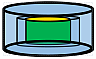
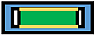

In [29]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=4, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=10, radius=1, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    reference = make_vertical_cylinder(roi_num=11, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole, middle_cylinder, reference])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.

In [30]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(dual_embedded_cylinder(), [1, 2]))


In [31]:
def overlapping_cylinders():
    slice_spacing = 0.5
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two overlapping cylinders
    top_cylinder = make_vertical_cylinder(roi_num=7, radius=2, length=0.4, offset_z=-0.3, spacing=slice_spacing)
    bottom_cylinder = make_vertical_cylinder(roi_num=8, radius=2, length=0.4, offset_z=0, spacing=slice_spacing)
   # combine the contours
    slice_data = pd.concat([top_cylinder, bottom_cylinder, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(overlapping_cylinders(), [7, 8]))


## Missing secondary boundary test

# More Tests Needed

  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
- **Partition**
  - Concentric cylinders ending on the same slice.
  - Concentric cylinders starting on the same slice
  - Primary: Central Cylinder
    - Single Secondary slice with circular contour on the SUP/INF slice of the Primary cylinder.
  - Single Primary slice with circular contour
    - Secondary: one of:
      - SUP Cylinder ending on the same slice.
      - INF Cylinder ending on the same slice.
- **CONTAINS**
  - Concentric cylinders with interior cylinder ending inside the exterior cylinder by one slice
**OVERLAPS**
  - Concentric cylinders with interior cylinder ending outside the exterior cylinder by one slice
  - Concentric cylinders with interior cylinder consisting of single slice ending inside the exterior cylinder by one slice


  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.
  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
